## use it in PyTorch

In [3]:
data_dir = "data"
# data_dir = "lexicalized_data"

from dataset import syntax_token_type
syntax_vocabulary, blacklist = syntax_token_type(data_dir)

encountering ambiguous tag at data/sw2260#s283_500/syntax.txt, break-tied
encountering type II typo at data/sw2249#s67_500/syntax.txt, blacklisted
encountering type II typo at data/sw2789#s226_500/syntax.txt, blacklisted
encountering type II typo at data/sw2229#s140_500/syntax.txt, blacklisted
encountering type II typo at data/sw2589#s154_500/syntax.txt, blacklisted
encountering type II typo at data/sw2067#s50_500/syntax.txt, blacklisted
encountering type II typo at data/sw2154#s6_500/syntax.txt, blacklisted
encountering ambiguous tag at data/sw2015#s53_500/syntax.txt, break-tied
encountering type II typo at data/sw2079#s10_500/syntax.txt, blacklisted
encountering type II typo at data/sw2434#s87_500/syntax.txt, blacklisted
encountering a weird semicolon at data/sw3049#s167_500/syntax.txt, blacklisted
encountering type II typo at data/sw2229#s232_500/syntax.txt, blacklisted
encountering type II typo at data/sw2249#s194_500/syntax.txt, blacklisted
encountering type II typo at data/sw2641

In [4]:
if data_dir == "data":
    print(syntax_vocabulary)
print(len(syntax_vocabulary))
print(blacklist)

{'!': 0, '.': 1, '?': 2, 'ADJP': 3, 'ADVP': 4, 'BES': 5, 'CC': 6, 'CD': 7, 'CONJP': 8, 'DT': 9, 'EDITED': 10, 'EX': 11, 'FRAG': 12, 'FW': 13, 'GW': 14, 'HVS': 15, 'IN': 16, 'INTJ': 17, 'JJ': 18, 'JJR': 19, 'JJS': 20, 'LS': 21, 'LST': 22, 'MD': 23, 'NAC': 24, 'NN': 25, 'NNP': 26, 'NNPS': 27, 'NNS': 28, 'NP': 29, 'NX': 30, 'PDT': 31, 'POS': 32, 'PP': 33, 'PRN': 34, 'PRP': 35, 'PRP$': 36, 'PRT': 37, 'QP': 38, 'RB': 39, 'RBR': 40, 'RBS': 41, 'RP': 42, 'RRC': 43, 'S': 44, 'SBAR': 45, 'SBARQ': 46, 'SINV': 47, 'SQ': 48, 'SYM': 49, 'TO': 50, 'TRACE': 51, 'TYPO': 52, 'UCP': 53, 'UH': 54, 'UNK': 55, 'VB': 56, 'VBD': 57, 'VBG': 58, 'VBN': 59, 'VBP': 60, 'VBZ': 61, 'VP': 62, 'WDT': 63, 'WHADJP': 64, 'WHADVP': 65, 'WHNP': 66, 'WHPP': 67, 'WP': 68, 'WP$': 69, 'WRB': 70, 'X': 71, 'XX': 72, '[': 73, ']': 74}
75
{'data/sw2154#s6_500', 'data/sw2249#s148_500', 'data/sw2229#s91_500', 'data/sw2078#s154_500', 'data/sw2249#s67_500', 'data/sw2641#s78_500', 'data/sw2719#s157_500', 'data/sw2249#s149_500', 'data

In [13]:
from dataset import Phase, get_dataloader

dataloader = get_dataloader(
    root=data_dir, phase=Phase.TRAIN, syntax_vocabulary=syntax_vocabulary, blacklist=blacklist,
    batch_size=4, shuffle=True, num_workers=2,
    return_original=True  # we want the raw audio returned as well
)

This is only for demo. You probably will never call ```pad_packed_sequence``` explicitly, which wastes a good deal of memory

In [14]:
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence
from dataset import restore_order
import numpy as np

for speech, mfcc, syntax in dataloader:
    speech, inv_perm_index_speech = speech
    mfcc, inv_perm_index_mfcc = mfcc
    syntax, inv_perm_index_syntax = syntax
    assert type(speech) == PackedSequence
    assert type(mfcc) == PackedSequence
    assert type(syntax) == PackedSequence  # PackedSequence can be fed into a RNN directly
    
    # okay let's pretend there's a RNN and we are through it
    unpacked_speech, unpacked_speech_len = pad_packed_sequence(speech, batch_first=True)
    # restore order
    unpacked_speech = restore_order(unpacked_speech, inv_perm_index_speech)
    unpacked_speech_len = np.take(unpacked_speech_len, inv_perm_index_speech)
    print("speech batch")
    print(unpacked_speech.shape)
    print(unpacked_speech_len)
    
    unpacked_mfcc, unpacked_mfcc_len = pad_packed_sequence(mfcc, batch_first=True)
    # restore order
    unpacked_mfcc = restore_order(unpacked_mfcc, inv_perm_index_mfcc)
    unpacked_mfcc_len = np.take(unpacked_mfcc_len, inv_perm_index_mfcc)
    print("mfcc batch")
    print(unpacked_mfcc.shape)
    print(unpacked_mfcc_len)
    
    unpacked_syntax, unpacked_syntax_len = pad_packed_sequence(syntax, batch_first=True)
    # restore order
    unpacked_syntax = restore_order(unpacked_syntax, inv_perm_index_syntax)
    unpacked_syntax_len = np.take(unpacked_syntax_len, inv_perm_index_syntax)
    print("syntax batch")
    print(unpacked_syntax.shape)
    print(unpacked_syntax_len)
    
    print("It's only a demo, people.")
    break

SHAPE:  torch.Size([11, 13]) torch.Size([17, 13])
SHAPE:  torch.Size([54, 13]) torch.Size([164, 13])
SHAPE:  torch.Size([35, 13]) torch.Size([60, 13])
SHAPE:  torch.Size([12, 13]) torch.Size([114, 13])
speech batch
torch.Size([4, 52973])
tensor([ 5538,  8365,  4960, 52973])
mfcc batch
torch.Size([4, 104, 13])
tensor([ 11,  17,  10, 104])
syntax batch
torch.Size([4, 111])
tensor([ 30,  27,  24, 111])
It's only a demo, people.


In [15]:
import IPython
import IPython.display as ipd
from nltk.tree import Tree
import librosa.display
import matplotlib.pyplot as plt


def display_speech(unpacked_speech, unpacked_speech_len):
    auds = []
    for s, l in zip(unpacked_speech, unpacked_speech_len):
        speech = s[:l].numpy()
        auds.append(ipd.Audio(speech, rate=8000))
    return auds


def display_mfcc(unpacked_mfcc, unpacked_mfcc_len):
    for s, l in zip(unpacked_mfcc, unpacked_mfcc_len):
        mfcc = s[:l].numpy().T  # [n_mfcc, t]
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, sr=8000, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()


def display_syntax(unpacked_syntax, unpacked_syntax_len):
    for s, l in zip(unpacked_syntax, unpacked_syntax_len):
        indices = s[:l].numpy()
        tokens = []
        for i in indices:  # turn indices into human-readable strings
            for k, v in syntax_vocabulary.items():
                if v == i:
                    tokens.append(k)
                    break
        syntax = "".join(tokens)
        print(syntax)
        tree = Tree.fromstring(syntax, brackets="[]")
        IPython.core.display.display(tree)


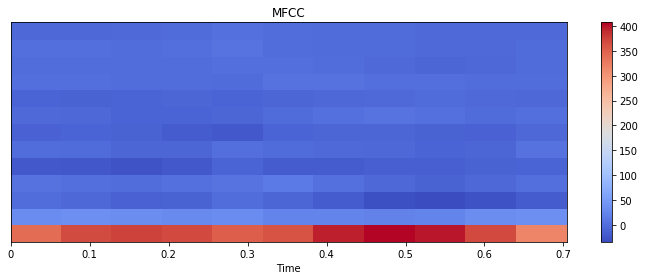

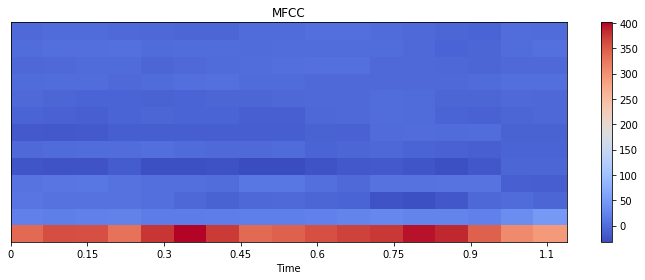

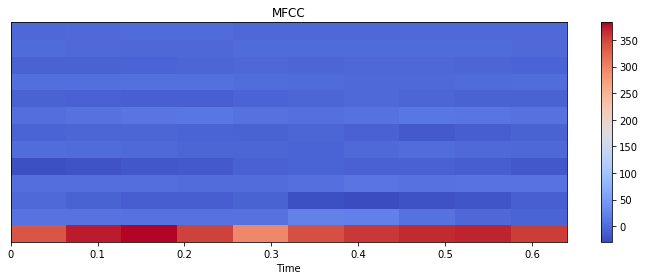

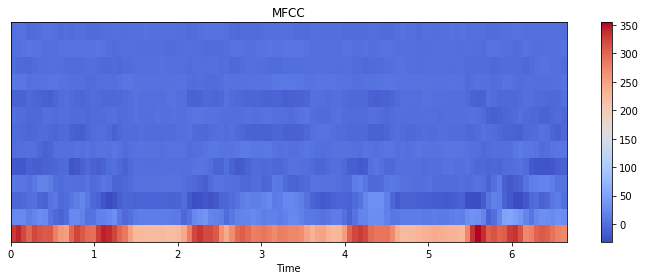

In [16]:
auds = display_speech(unpacked_speech, unpacked_speech_len)
display_mfcc(unpacked_mfcc, unpacked_mfcc_len)

[S[ADVP[RB]][NP[PRP]][VP[VBP][ADVP[TRACE]]][.]]


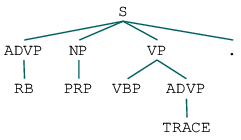

[S[NP[PRP]][VP[VBP][NP[DT][NNS]]][.]]


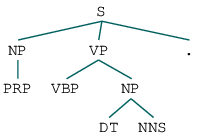

[S[NP[DT]][VP[BES][ADJP[JJ]]][.]]


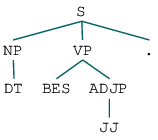

[S[CC][NP[PRP]][VP[VBP][VP[VBN][NP[TRACE]][PRT[RP]][INTJ[UH]][PRN[S[NP[PRP]][VP[MD][VP[VB][NP[TRACE]]]]]][NP[NP[QP[RB][CD]]][PP[IN][NP[DT][CD][NN][NN]]]]]][.]]


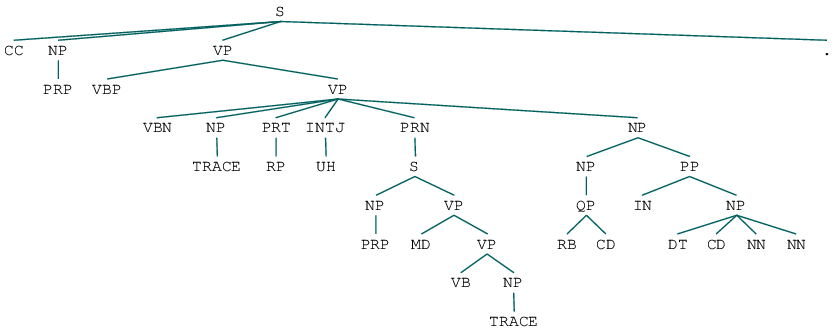

In [17]:
display_syntax(unpacked_syntax, unpacked_syntax_len)

In [25]:
auds[0]

In [26]:
auds[1]

In [27]:
auds[2]

In [28]:
auds[3]